In [322]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx

In [323]:
df_obs = pd.read_csv("data/5-assignhwy/observed-volumes.csv")
df_mod = pd.read_csv("data/5-assignhwy/WFv910_OY_2023_Summary_SEGID.csv")
df_ft = df_mod[['SEGID','FTCLASS']]

FileNotFoundError: [Errno 2] No such file or directory: 'data/5-assignhwy/WFv910_OY_2023_Summary_SEGID.csv'

In [312]:
df_obs[['data']] = 'Observed'
df_mod[['data']] = 'Modeled'

In [313]:
df_mod1 = df_mod[['SEGID','CO_FIPS','DISTANCE','DY_Vol','DY_Vol_PC','DY_Vol_MD','DY_Vol_HV']].rename(columns={'DY_Vol':'Mod_AWDT','DY_Vol_PC':'Mod_Car','DY_Vol_MD':'Mod_MD','DY_Vol_HV':'Mod_HV'})
df_obs1 = df_obs[['SEGID', 'Obs_AWDT', 'Obs_Car', 'Obs_MD', 'Obs_HV']]
allveh = pd.merge(df_mod1,df_obs1,on='SEGID',how='left')
allveh = pd.merge(allveh,df_ft, on='SEGID', how='left')
allveh

,SEGID,CO_FIPS,DISTANCE,Mod_AWDT,Mod_Car,Mod_MD,Mod_HV,Obs_AWDT,Obs_Car,Obs_MD,Obs_HV,FTCLASS
0,0006_141.0,49.0,5.843,1644.1,1372.1,152.0,120.0,1492.728,1346.857127,51.900660,93.970213,Principal Arterial
1,0006_146.9,49.0,3.039,1648.5,1374.5,153.0,120.0,1492.728,1346.857127,51.900660,93.970213,Principal Arterial
2,0006_149.9,49.0,0.678,1597.7,1153.6,179.4,86.2,2401.944,1949.021430,226.822778,226.099793,Principal Arterial
3,0006_150.6,49.0,1.973,1751.5,1247.6,197.3,91.6,2401.944,1949.021430,226.822778,226.099793,Principal Arterial
4,0006_152.6,49.0,0.316,2363.4,1542.2,289.5,136.2,2378.328,1713.801752,366.493210,298.033038,Minor Arterial
...,...,...,...,...,...,...,...,...,...,...,...,...
4402,WFRC_8486,35.0,0.501,1820.2,1338.9,177.0,47.8,NaN,NaN,NaN,NaN,Collector
4403,WFRC_8487,35.0,0.501,1127.8,900.1,81.7,24.7,NaN,NaN,NaN,NaN,Collector
4404,WFRC_8488,35.0,0.529,2789.1,2140.7,230.6,98.8,NaN,NaN,NaN,NaN,Collector
4405,WFRC_8491,35.0,0.265,462.7,322.6,47.1,4.2,NaN,NaN,NaN,NaN,Collector


In [314]:
df_obs = df_obs[['SEGID','data','Obs_AWDT','Obs_Car','Obs_MD','Obs_HV']].rename(columns={'Obs_AWDT':'Total','Obs_Car':'Car','Obs_MD':'MD','Obs_HV':'HV'})

df_mod['Car'] = df_mod['DY_Vol_PC'] + df_mod['DY_Vol_LT']
df_mod = df_mod.rename(columns={'DY_Vol':'Total','DY_Vol_MD':'MD','DY_Vol_HV':'HV'})
df_mod = df_mod[['SEGID','data','Total', 'Car','MD', 'HV']]

In [315]:
dfSegSum = pd.concat([df_mod,df_obs],ignore_index=True)
dfSegSum = pd.merge(dfSegSum,df_ft,on='SEGID',how='left')

In [316]:
# read segment shapefile into spatial enabled dataframe
dirSegShp = r'D:\GitHub\WF-TDM-v9x\1_Inputs\6_Segment\WFv910_Segments.shp'
segShp = gpd.read_file(dirSegShp)
segShp.head()
segShp = segShp[['SEGID','geometry']]

In [399]:
def plot_volume_diff(segSum, varOption, segShp):
    scenario1 = 'Modeled'
    scenario2 = 'Observed'

    segSum = segSum[['SEGID', 'FTCLASS', 'data', varOption]]
    dfSegSum1 = segSum.query('data == @scenario1')
    dfSegSum2 = segSum.query('data == @scenario2')

    dfSegSum2[varOption] *= -1
    dfSegSumDiff = pd.merge(dfSegSum1, dfSegSum2, on= ['SEGID'], how='left')
    dfSegSumDiff['diff'] = dfSegSumDiff[varOption + '_x'] + dfSegSumDiff[varOption + '_y']
    dfSegSumDiff['FTCLASS'] = dfSegSumDiff['FTCLASS_x']

    sdfSegSumDiff = segShp.merge(dfSegSumDiff, on = 'SEGID')

    conditions = [
        (sdfSegSumDiff['diff'].lt(-10000)),
        (sdfSegSumDiff['diff'].ge(-10000) & sdfSegSumDiff['diff'].lt(-3000)),
        (sdfSegSumDiff['diff'].ge(-3000) & sdfSegSumDiff['diff'].lt(-1000)),
        (sdfSegSumDiff['diff'].ge(-1000) & sdfSegSumDiff['diff'].lt(1000)),
        (sdfSegSumDiff['diff'].ge(1000) & sdfSegSumDiff['diff'].lt(3000)),
        (sdfSegSumDiff['diff'].ge(3000) & sdfSegSumDiff['diff'].le(10000)),
        (sdfSegSumDiff['diff'].gt(10000)),
    ]
    choices = [2.4,2,1.7,1.7,1.7,2,2.4]
    sdfSegSumDiff["lw"] = np.select(conditions, choices)
    sdfSegSumDiff['lwf'] = np.where(sdfSegSumDiff['FTCLASS'] == 'Freeway', sdfSegSumDiff['lw'], sdfSegSumDiff['lw'] - 1.6)

    # Create the figure and axis
    fig, ax = plt.subplots()

    # Print current CRS
    print("Current CRS:", sdfSegSumDiff.crs)

    # Check and set CRS if necessary
    if sdfSegSumDiff.crs is None:
        # Assuming your original data is in EPSG:4326 (WGS84)
        sdfSegSumDiff.set_crs(epsg=26912, inplace=True)

    # Check if we need to reproject to Web Mercator
    if sdfSegSumDiff.crs.to_string() != 'EPSG:3857':
        sdfSegSumDiff = sdfSegSumDiff.to_crs(epsg=3857)
    
    bin1 = [-15000, -7500, -2500, 0, 2500, 7500, 15000]
    bin2 = [-5000, -1500, -500, 0, 500, 1500, 5000]
    
    if varOption=='Total':
        bin = bin1
    else:
        bin = bin2
    
    # Plot your geospatial data
    sdfSegSumDiff.plot(
        column='diff', 
        cmap='RdBu', 
        scheme="userdefined", 
        legend=True, 
        classification_kwds=dict(bins=bin),
        linewidth=sdfSegSumDiff['lwf'], 
        ax=ax,
        antialiased=False
    )

    # Add basemap using contextily with OpenStreetMap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha=1)

    # Adjust the margins and axis
    ax.margins(0.1)
    ax.axis('off')

    # Adjust the x-axis limits to cut off the right side of the map
    xlim = ax.get_xlim()  # Get current x-axis limits
    cutoff_value = xlim[1] - 65000  # Define how much you want to cut off (adjust value as needed)
    ax.set_xlim(xlim[0], cutoff_value)  # Set new x-axis limits


    # Adjust legend size
    leg = ax.get_legend()  # Get the current legend
    leg.set_bbox_to_anchor((1, 1))  # Move the legend outside the plot area if necessary
    leg.set_title('Difference Scale', prop={'size': 8})  # Adjust the title size
    for text in leg.get_texts():
        text.set_fontsize(8)  # Adjust the size of the legend text


    # Show the plot
    plt.rcParams["figure.figsize"]=6,12
    plt.savefig(f'_pictures/vol-diff-{varOption}.png', bbox_inches='tight', dp=12000)
    plt.tight_layout()


C:\Users\cday\AppData\Local\Temp\ipykernel_24536\4189449411.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfSegSum2[varOption] *= -1


Current CRS: EPSG:26912


C:\Users\cday\AppData\Local\Temp\ipykernel_24536\4189449411.py:87: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dp" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'_pictures/vol-diff-{varOption}.png', bbox_inches='tight', dp=12000)


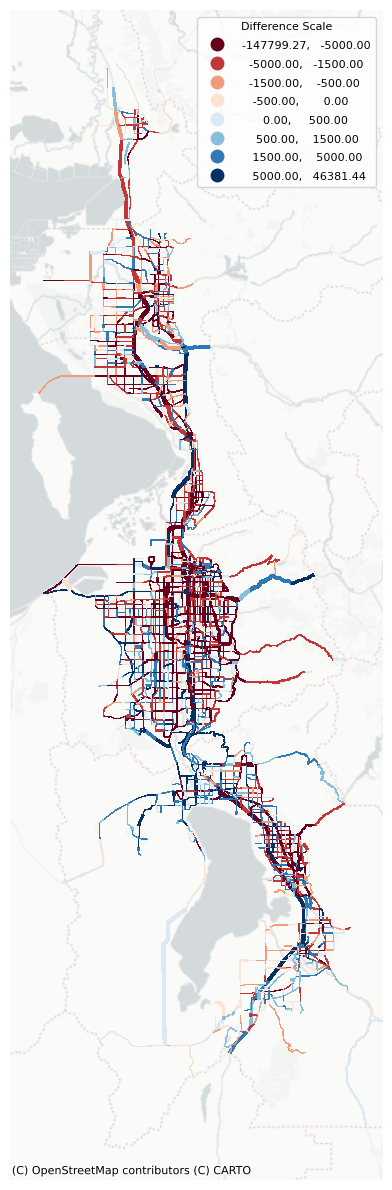

In [400]:
plot_volume_diff(dfSegSum,'Car', segShp)